# Time Analysis


You can create a simple time analysis of a classified trajectory by using the [transition submodule](generated/SOAPify.transitions.rst#module-SOAPify.transitions)

The time analysis works with the concepts of _windows_ and _stride_.

The _window_ is the number of frame between wich the state of an atom is confronted, the more is higher the _window_ the more time passes between the two states:
![](images/timeAnalysisWindows.png)

The _stride_  is how many frames the window with the confronatation is displaced during the analysis. A _stride_ must be alwayis inferior or equal to the value of the _window_:
![](images/timeAnalysisStrides.png)

If you want to analyze the trajectory as if it has been sampled at a slower rate simply use the same number for _window_ and _stride_:
![](images/timeAnalysisStridesEqualWindow.png)

In [1]:
import numpy.random as npr
import numpy as np
from scipy.stats import poisson, kstest, norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import SOAPify.transitions as st
from SOAPify import SOAPclassification
import seaborn as sns

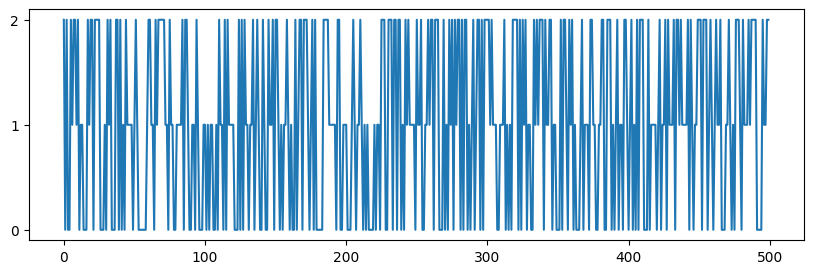

In [2]:
rng = npr.default_rng(12345)
cls=SOAPclassification(
    [],
    rng.integers(0, 3, size=(500,1)),
    [0,1,2]
    )
_,ax=plt.subplots(figsize=(10,3))
ax.set_yticks([0,1,2])
_ =ax.plot(cls.references[:,0])

<AxesSubplot: >

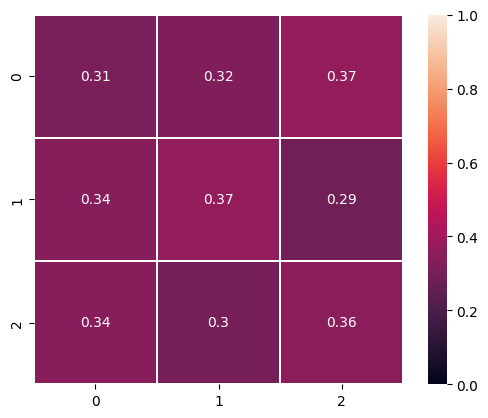

In [3]:
tmat = st.calculateTransitionMatrix(cls)
tmat= st.normalizeMatrix(tmat)
sns.heatmap(tmat, annot=True,linewidths=0.1,square=True,vmax=1, vmin=0)

## Example: a 4 states Markov chain

A simple 1 atom system with 4 states and possibility to evolve only to adiacent states

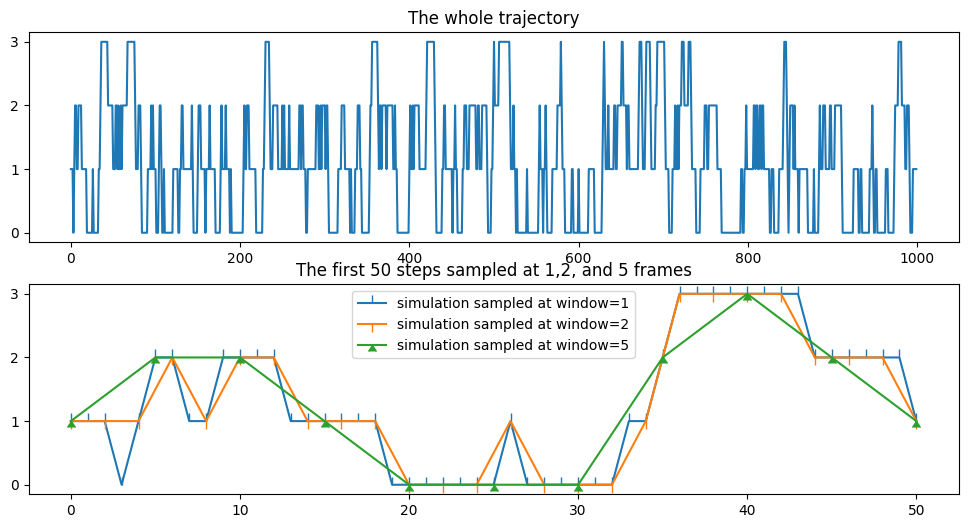

In [4]:
rng = npr.default_rng(123456)
nframes=1000
P=np.array([
    [0.8,0.2,0.0,0.0],
    [0.1,0.7,0.2,0.0],
    [0.0,0.3,0.6,0.1],
    [0.0,0.0,0.2,0.8],
            ])
#contstuct a target table:
target=P
for j in range(1,4):
    target[:,j]+=target[:,j-1]


cls=np.empty((nframes,1),dtype=int)
cls[0,0]=1
for i,c in enumerate(cls[:-1,0]):
    t=rng.random()
    cls[i+1,0]= np.argwhere(target[c]>t)[0]
cls=SOAPclassification(
    [],
    cls,
    [0,1,2,3]
    )
_,axes=plt.subplots(2,1,figsize=(12,6))
for ax in axes:
    ax.set_yticks([0,1,2,3])

axes[0].plot(cls.references[:,0])
axes[0].set_title("The whole trajectory")
axes[1].set_title("The first 50 steps sampled at 1,2, and 5 frames")
for window in [1,2,5]:
    axes[1].plot(np.arange(0,51,window),
            cls.references[:51:window,0],marker=window+1,
            label=f"simulation sampled at window={window}")
_=axes[1].legend()   

The transition matrices calculated changing the window value and the stride value

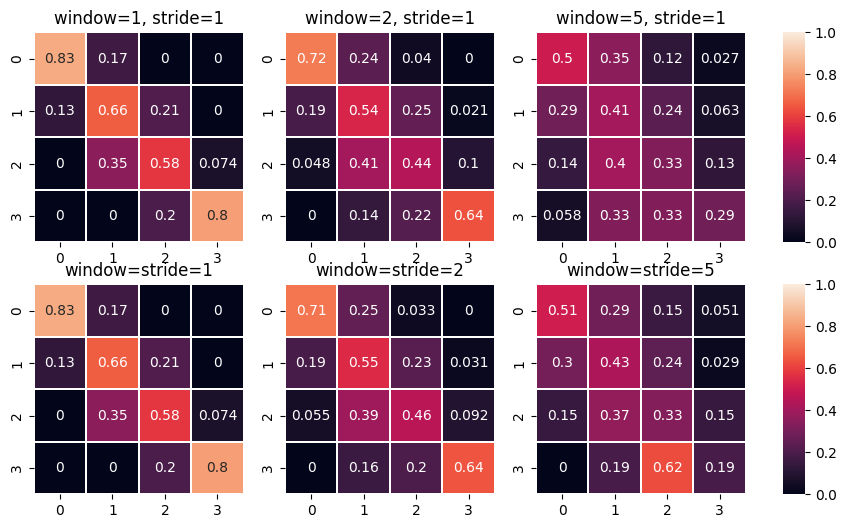

In [5]:
_,ax=plt.subplots(2,4,figsize=(10,6), gridspec_kw={'width_ratios':[1,1,1,0.1]})
for i, window in enumerate([1,2,5]):
    tmat = st.calculateTransitionMatrix(cls, window=window, stride=1)
    tmat= st.normalizeMatrix(tmat)
    sns.heatmap(tmat, annot=True,linewidths=0.1,
                square=True,vmax=1, vmin=0, ax = ax[0,i],
                cbar=i != 1,
                cbar_ax= ax[0,3] if i!=1  else None)
    ax[0,i].set_title(f"window={window}, stride=1")
for i, window in enumerate([1,2,5]):
    tmat = st.calculateTransitionMatrix(cls, window=window, stride=window)
    tmat= st.normalizeMatrix(tmat)
    sns.heatmap(tmat, annot=True,linewidths=0.1,
                square=True,vmax=1, vmin=0, ax = ax[1,i],
                cbar=i != 1,
                cbar_ax= ax[1,3] if i!=1  else None)
    ax[1,i].set_title(f"window=stride={window}")

### How to calculate and show the events
[calculateResidenceTimes](generated/SOAPify.transitions.html#SOAPify.transitions.calculateResidenceTimes) creates a list of residence time for each state of the given trajectory.
The algorithm will set the first and last residence time with a negative time, to suggest that these event are not correctly sampled.

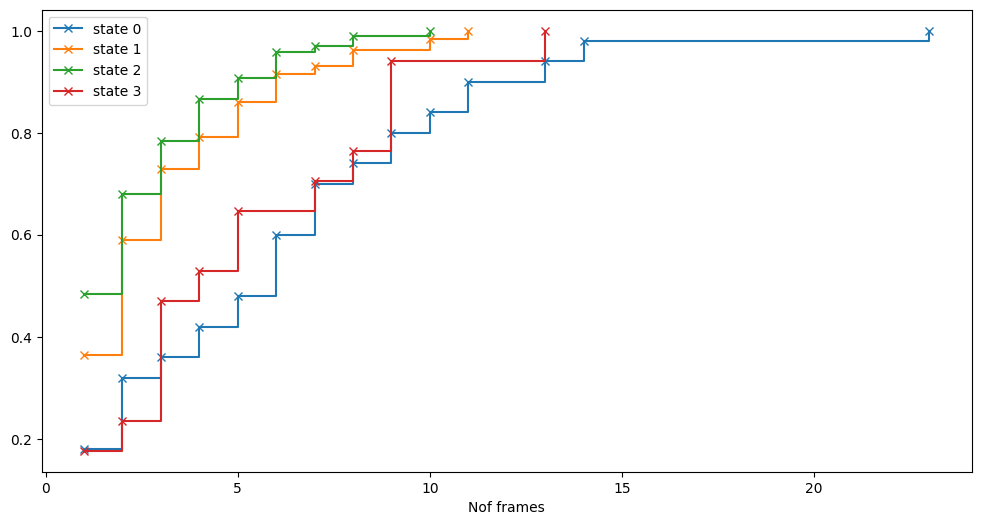

In [6]:
residenceTimes = st.calculateResidenceTimes(
        cls, stride=1, window=1
    )
_,ax=plt.subplots(figsize=(12,6))
for i,RT in enumerate(residenceTimes):
    completeRT=RT[RT>0]
    nOfCounts=len (completeRT)
    uniqueElements, counts=np.unique(completeRT,return_counts=True)
    for j in range(1,len(counts)):
        counts[j]+=counts[j-1]
    ax.step(uniqueElements, counts/nOfCounts,
            where='post',label = f"state {i}",
            marker='x', color=f"C{i}")
    #ys=(np.array(range(len (completeRT)))+1)/(len (completeRT))
    #ax.plot(completeRT, ys, label = f"state {i}", marker='o',color=f"C{i}")
ax.set_xlabel("Nof frames")
_=ax.legend()

You can estimate the transition time by fitting a cumulative  distribution function
against the cumulative of the points, and then by testing the correctness with a
Kolmogorov-Smirnov test.

Here we are using a Poissonian as an example distribution.

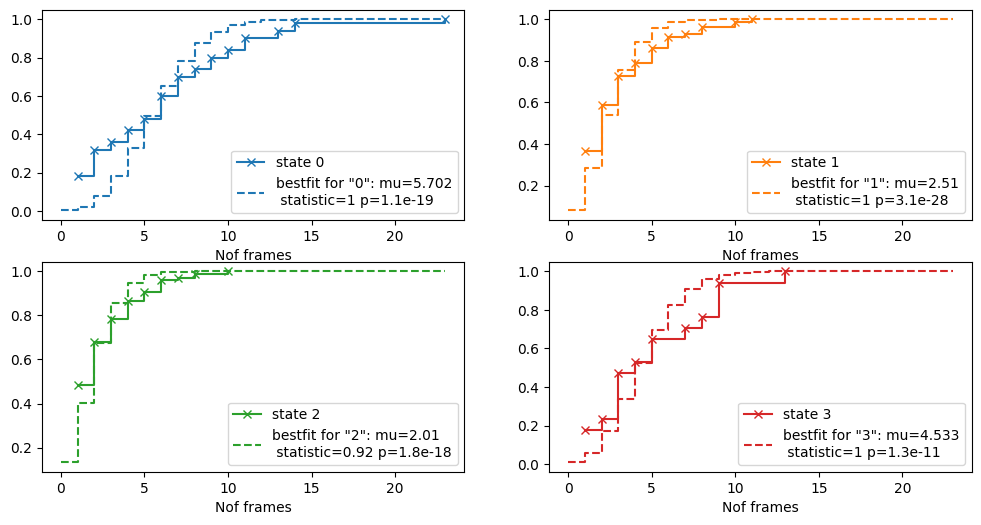

In [7]:
_,axes=plt.subplots(2,2,figsize=(12,6))
ax= axes.flatten()
xs= np.arange(np.amax([np.amax(RT) for RT in residenceTimes])+1)

for i,RT in enumerate(residenceTimes):
    completeRT=RT[RT>0]
    nOfCounts=len (completeRT)
    uniqueElements, counts=np.unique(completeRT,return_counts=True)
    for j in range(1,len(counts)):
        counts[j]+=counts[j-1]
    counts=counts/nOfCounts
    ax[i].step(uniqueElements,counts , where='post',label = f"state {i}",
            marker='x', color=f"C{i}")
    mu,_=curve_fit(poisson.cdf,uniqueElements,counts, p0=[1])
    ks=kstest(completeRT,poisson.cdf(xs,mu))
    ax[i].step(xs,poisson.cdf(xs,mu),where='post', color=f"C{i}",
            linestyle='--',
            label=f'bestfit for "{i}": mu={mu[0]:0.4g}\n statistic={ks[0]:.2g} p={ks[1]:.2g}')
    
    ax[i].set_xlabel("Nof frames")
    ax[i].legend()

And here we are using a normal as an example distribution

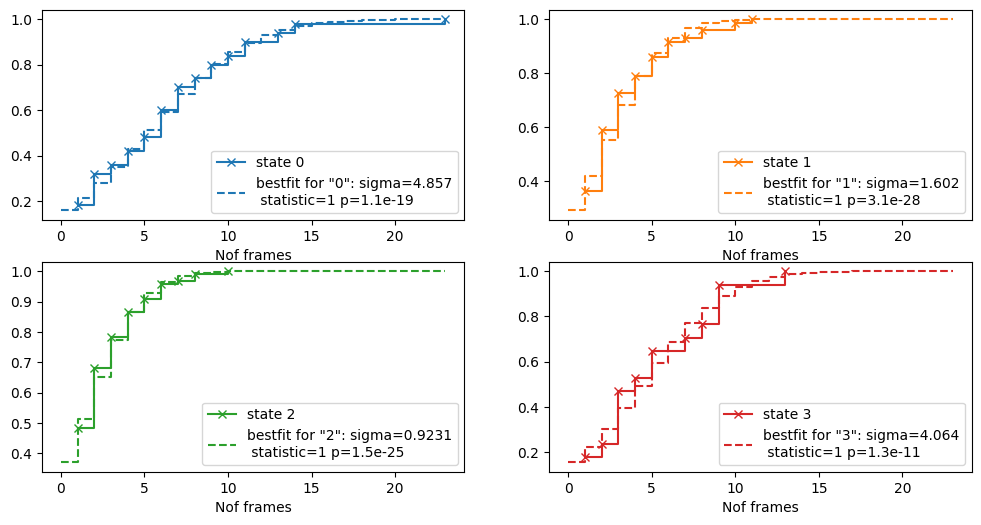

In [8]:
_,axes=plt.subplots(2,2,figsize=(12,6))
ax= axes.flatten()
xs= np.arange(np.amax([np.amax(RT) for RT in residenceTimes])+1)

for i,RT in enumerate(residenceTimes):
    completeRT=RT[RT>0]
    nOfCounts=len (completeRT)
    uniqueElements, counts=np.unique(completeRT,return_counts=True)
    for j in range(1,len(counts)):
        counts[j]+=counts[j-1]
    counts=counts/nOfCounts
    ax[i].step(uniqueElements,counts , where='post',label = f"state {i}",
            marker='x', color=f"C{i}")
    mu,_=curve_fit(norm.cdf,uniqueElements,counts, p0=[1,1])
    ks=kstest(completeRT,norm.cdf(xs,mu[0], mu[1]))
    ax[i].step(xs,norm.cdf(xs,mu[0], mu[1]),where='post', color=f"C{i}",
            linestyle='--',
            label=f'bestfit for "{i}": sigma={mu[0]:0.4g}\n statistic={ks[0]:.2g} p={ks[1]:.2g}')
    
    ax[i].set_xlabel("Nof frames")
    ax[i].legend()